### **NMF Topic Modelling Notebook**

1. Uses TF-IDF for feature extraction to form the initial document-term matrix
2. Uses NMF to discover topics

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

import itertools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.renderers.default = "svg"


In [2]:
# Using pre-processed and cleaned reviews
reviews_df = pd.read_csv('../data/processed/reviews.csv')
reviews_df["tokenized_text"] = reviews_df["cleaned_text"].str.split()
reviews_df.head()

,date,partially_cleaned_text,sentiment,cleaned_text,tokenized_text
0,18/6/21,This is a very healthy dog food. Good for thei...,1,healthy dog food good digestion also good smal...,"[healthy, dog, food, good, digestion, also, go..."
1,7/7/21,I've been very pleased with the Natural Balanc...,1,pleased natural balance dog food dogs issues d...,"[pleased, natural, balance, dog, food, dogs, i..."
2,18/6/21,"Before I was educated about feline nutrition, ...",1,educated feline nutrition allowed cats become ...,"[educated, feline, nutrition, allowed, cats, b..."
3,7/7/21,"My holistic vet recommended this, along with a...",1,holistic vet recommended along brands tried ca...,"[holistic, vet, recommended, along, brands, tr..."
4,1/7/21,I bought this coffee because its much cheaper ...,1,bought coffee much cheaper ganocafe organic re...,"[bought, coffee, much, cheaper, ganocafe, orga..."


In [3]:
reviews_df.sentiment.value_counts()


1    4030
0    1414
Name: sentiment, dtype: int64

# **Feature Extraction - TF-IDF**

In [4]:
custom_sw = ['great', 'taste', 'good', 'like', 'product', 'flavor', 'love',
             'really', 'buy', 'tastes', 'better', 'best', 'tried', 'use', 'eat', 'food', 'make']
my_stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_sw))

In [13]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 1),
    stop_words=my_stop_words,
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(reviews_df['tokenized_text'])

# **Topic Modelling - NMF**

In [6]:
nmf = NMF(
    n_components=10,
    init='nndsvd',
    max_iter=500)

In [7]:
nmf = nmf.fit(tfidf)
components_df = pd.DataFrame(
    nmf.components_, columns=tfidf_vectorizer.get_feature_names_out())

print(tfidf.shape)  # reviews x words
print(nmf.transform(tfidf).shape)  # reviews x topics
print(nmf.components_.shape)  # topics x words

(5444, 4716)
(5444, 10)
(10, 4716)


In [8]:
reviews_topics = nmf.transform(tfidf)

# Number of reviews under each topic
pd.DataFrame(reviews_topics).idxmax(axis=1).value_counts()


0    1116
7     924
3     728
4     463
2     455
9     453
8     349
1     338
5     311
6     307
dtype: int64

In [9]:
def get_n_topics(num_topics, tfidf):

    nmf = NMF(
        n_components=num_topics,
        init='nndsvd',
        max_iter=500
    ).fit(tfidf)

    return nmf


def get_top_n_words(nmf_df, tfidf_vectorizer, n):

    components_df = pd.DataFrame(
        nmf_df.components_, columns=tfidf_vectorizer.get_feature_names_out())
    topic_value = components_df.reset_index().rename(
        columns={'index': 'topic'})
    topic_value = pd.melt(topic_value, id_vars='topic',
                          var_name='word', value_name='score')
    topic_value = topic_value.sort_values(['topic', 'score'], ascending=[
                                          True, False]).groupby('topic').head(n)

    return topic_value


def visualise_top_words(top_n_words_df, n_topics):

    colors = itertools.cycle(
        ["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])

    subplot_titles = [f"Topic {topic}" for topic in range(n_topics)]
    columns = 4
    rows = int(np.ceil(n_topics/columns))
    fig = make_subplots(rows=rows,
                        cols=columns,
                        shared_xaxes=False,
                        horizontal_spacing=.1,
                        vertical_spacing=.4 / rows if rows > 1 else 0,
                        subplot_titles=subplot_titles)

    row = 1
    column = 1
    for topic in range(n_topics):

        fig.add_trace(
            go.Bar(x=top_n_words_df[top_n_words_df['topic'] == topic]["score"],
                   y=top_n_words_df[top_n_words_df['topic'] == topic]['word'],
                   orientation='h',
                   marker_color=next(colors)),
            row=row, col=column)

        if column == columns:
            column = 1
            row += 1
        else:
            column += 1

    fig.update_layout(
        template="plotly_white",
        showlegend=False,
        title={
            'text': "Top Words",
            'x': .5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=1000,
        height=250*rows if rows > 1 else 250 * 1.3,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
    )

    return fig.show()

**Exploring a range of number of topics**


5 Topics


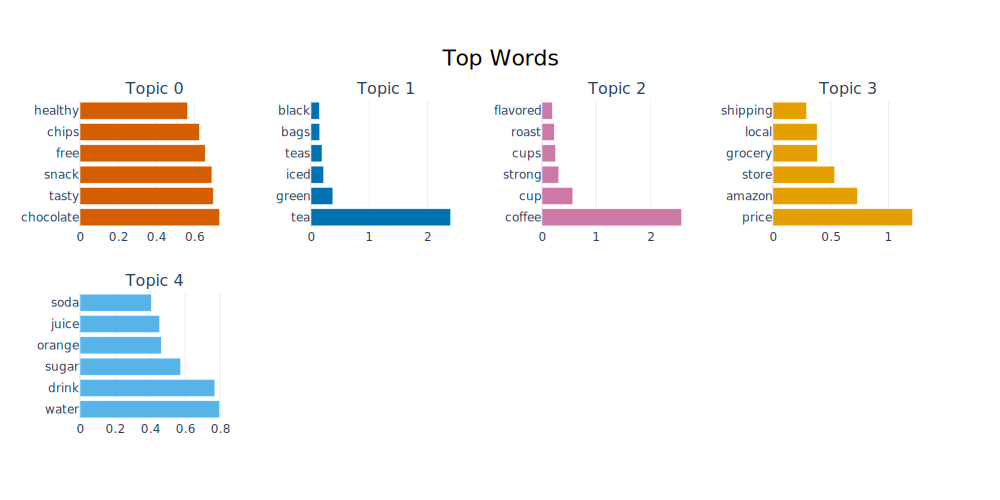

10 Topics


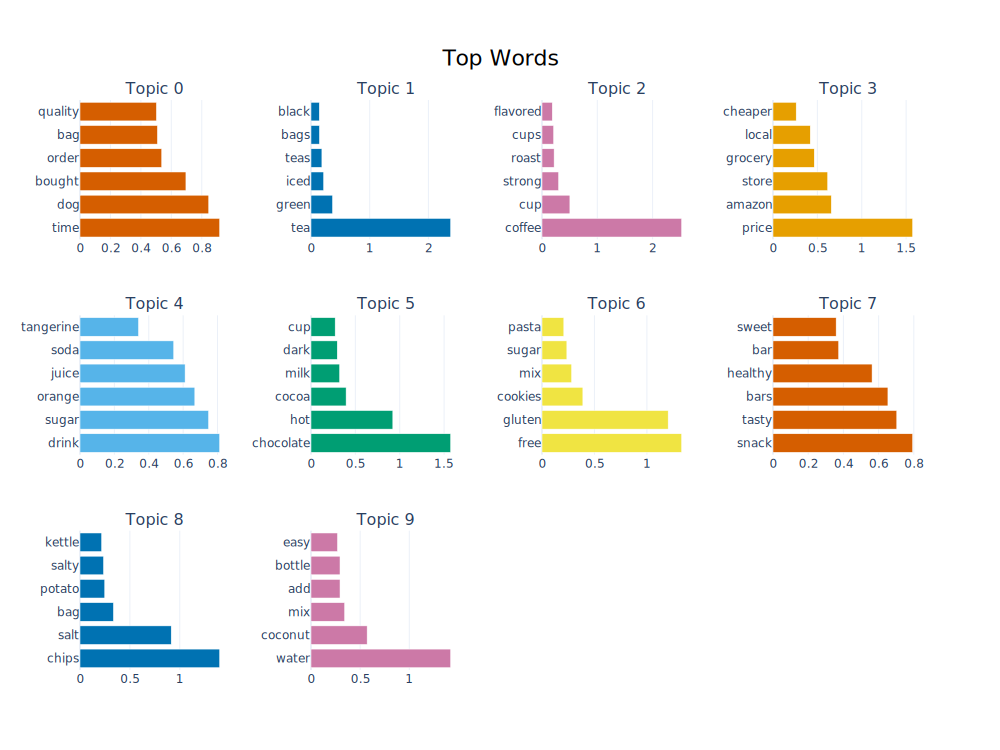

15 Topics


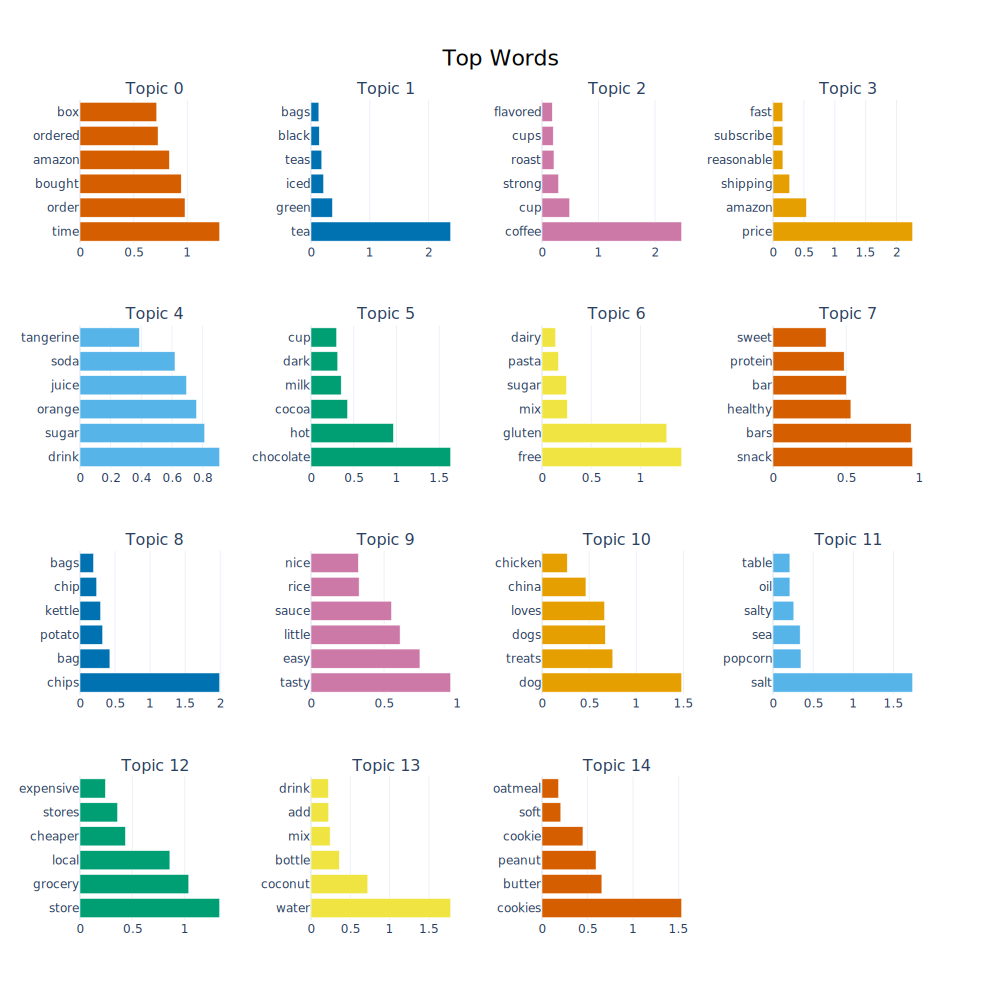

20 Topics


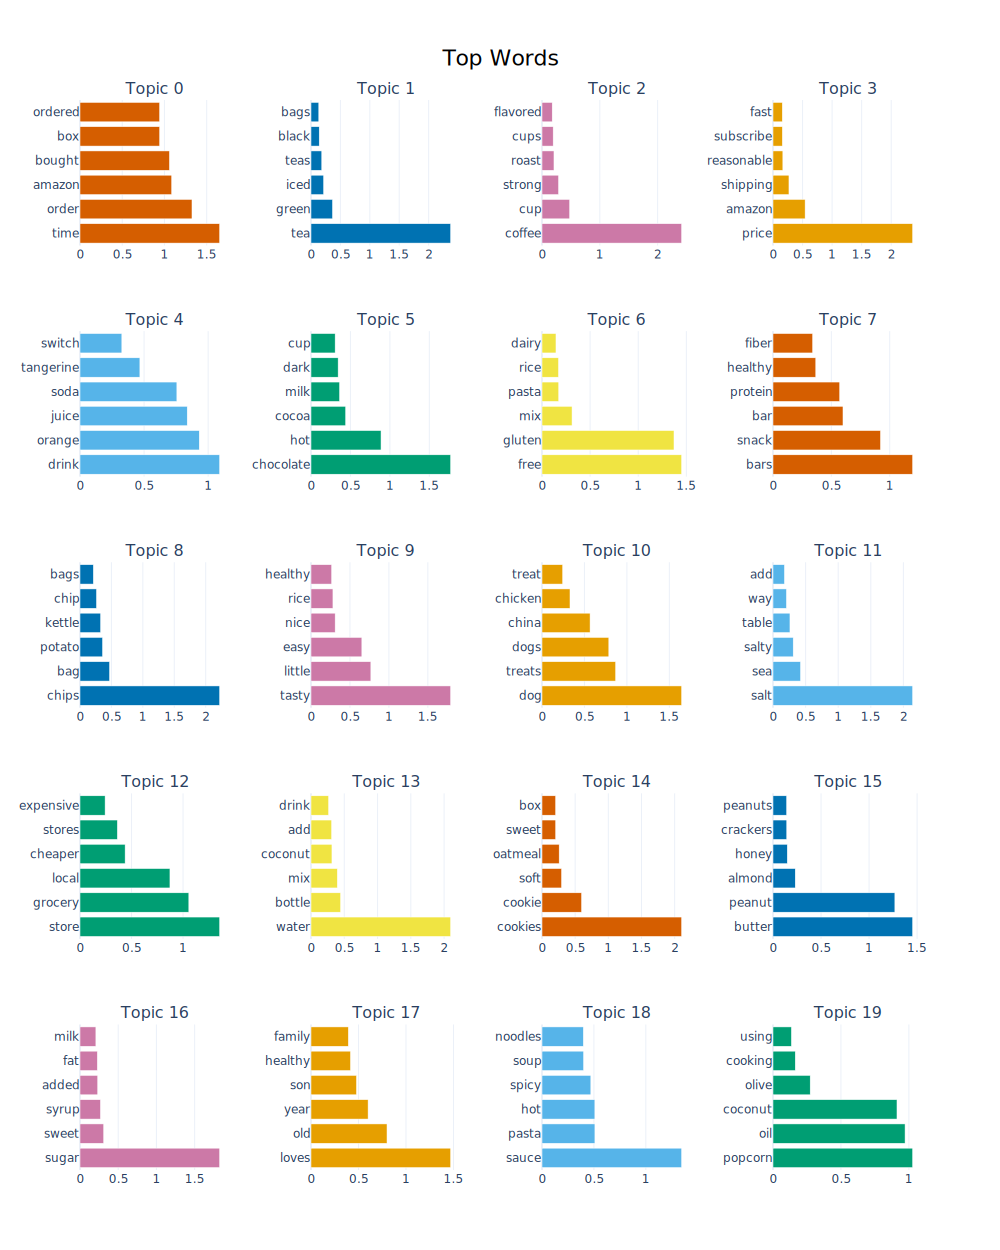

25 Topics


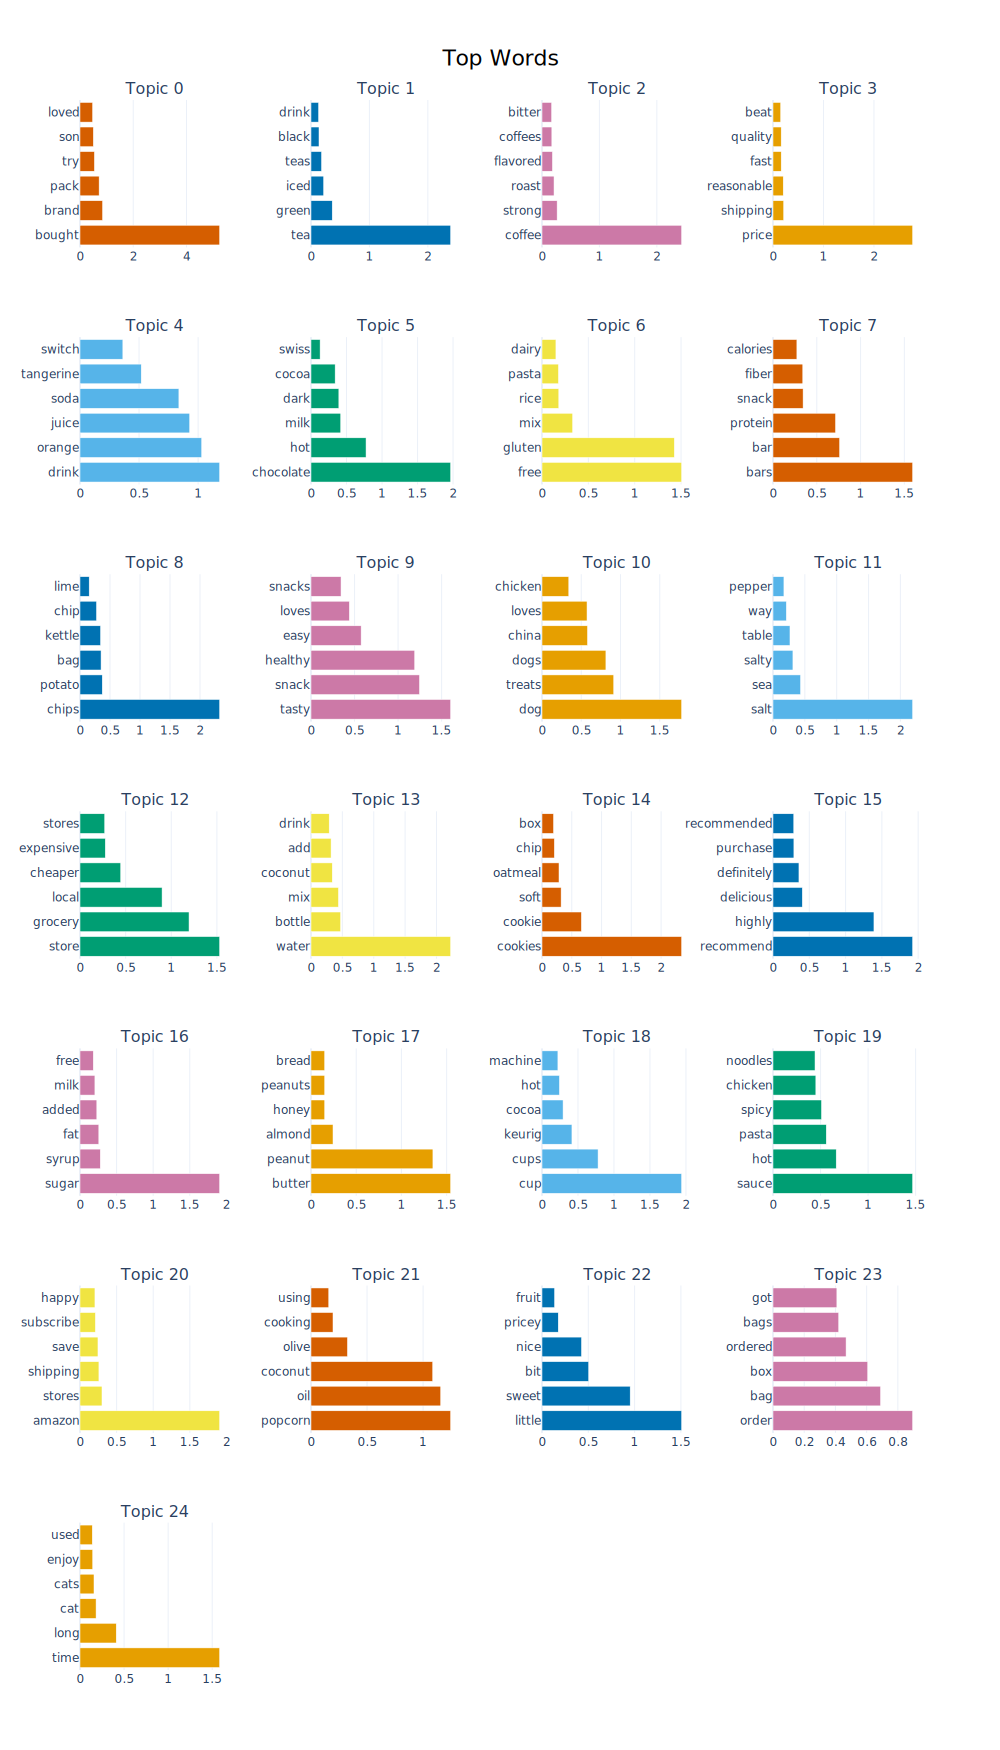

In [10]:
num_words = 6

tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 1),
    stop_words=my_stop_words,
    preprocessor=' '.join
)

for num_topics in [5, 10, 15, 20, 25]:
    print(f'{num_topics} Topics')
    tfidf = tfidf_vectorizer.fit_transform(reviews_df['tokenized_text'])
    top_n_words_df = get_top_n_words(get_n_topics(
        num_topics, tfidf), tfidf_vectorizer, num_words)
    visualise_top_words(top_n_words_df, num_topics)

Based on the 25 topics derived, some of the possible topics are:

0. --
1. tea
2. coffee
3. shipping/pricing
4. soda/juice
5. chocolate
6. pasta/rice
7. snack
8. chips
9. --
10. dog treats
11. salt/pepper
12. pricing
13. coconut water
14. cookies
15. --
16. ingredients
17. nuts/spreads
18. coffee/cocoa machine
19. shipping
20. good reviews
21. --
22. --
23. healthy ingredients
24. oil